## Data Exploration 

### 1. Build Data Frame from the source files

In [ ]:
import zipfile
import os

files = zipfile.ZipFile('food101.zip', 'r')
files.extractall(os.getcwd())
files.close()  

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import seaborn as sns

In [3]:
path = Path('food101')
path_meta = path /'meta'
path_images = path/'images'

In [4]:
path_meta

PosixPath('food101/meta')

In [5]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [6]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

In [7]:
train_df.head()

label             image_file
0  apple_pie  apple_pie/1005649.jpg
1  apple_pie  apple_pie/1014775.jpg
2  apple_pie  apple_pie/1026328.jpg
3  apple_pie  apple_pie/1028787.jpg
4  apple_pie  apple_pie/1043283.jpg

In [8]:
test_df.head()

label             image_file
0  apple_pie  apple_pie/1011328.jpg
1  apple_pie   apple_pie/101251.jpg
2  apple_pie  apple_pie/1034399.jpg
3  apple_pie   apple_pie/103801.jpg
4  apple_pie  apple_pie/1038694.jpg

### 2. Data Block API 
- The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:
 - Where are the inputs and how to create them?
 - How to split the data into a training and validation sets?
 - How to label the inputs?
 - What transforms to apply?
 - How to add a test set?
 - How to wrap in dataloaders and create the DataBunch?
 
- Build Data Block from dataframe

In [9]:
bs = 64

In [10]:
# Explore the dataset

train_data = ImageList.from_df(df=train_df,path=path_images, cols=1)\
              .split_by_rand_pct(0.2)\
              .label_from_df(cols=0)\
              .transform(get_transforms(), size=224)\
              .databunch(bs=bs)
 
              

In [11]:
train_data

ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sushi,french_onion_soup,bruschetta,tiramisu,fish_and_chips
Path: food101/images;

Test: None

In [12]:
print('Total data classes:',str(len(train_data.classes)))
print('Food Classes: \n', train_data.classes)

Total data classes: 101
Food Classes: 
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'mac

### 3. Explore the Image

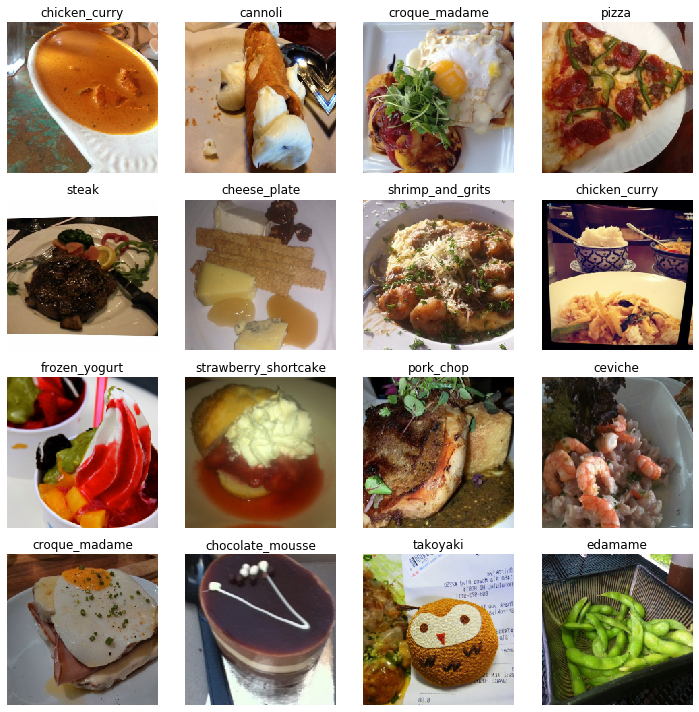

In [13]:
train_data.show_batch(rows=4, figsize=(10, 10))

In [14]:
train_data.classes[0]

'apple_pie'

### 3.1 Explore each Class images
- Build the two functions
  - function `build_class_data` is to build all same class images via Data Block API
  - function `show_class_images` is to show images of each class

In [15]:
np.random.seed(2)
def build_class_data(class_name):
    
    class_path = path_images/class_name
    fnames = get_image_files(class_path)
    pat = r'/([^/]+)/\d+.jpg$'
    class_data = ImageDataBunch.from_name_re(class_path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

    return class_data



In [16]:
def show_class_images(class_name, row_number = 4, fig_size = (10,10)):
    
    class_data = build_class_data(class_name)
    print('Class Name: ', class_name)
    class_data.show_batch(rows=row_number, figsize=fig_size)
    
    return

    

Class Name:  apple_pie


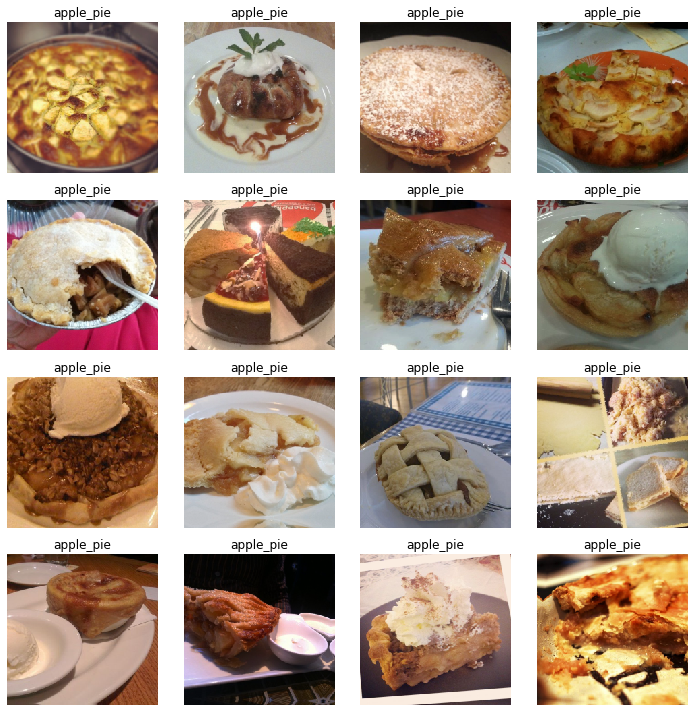

In [17]:
show_class_images(train_data.classes[0])

Class Name:  bruschetta


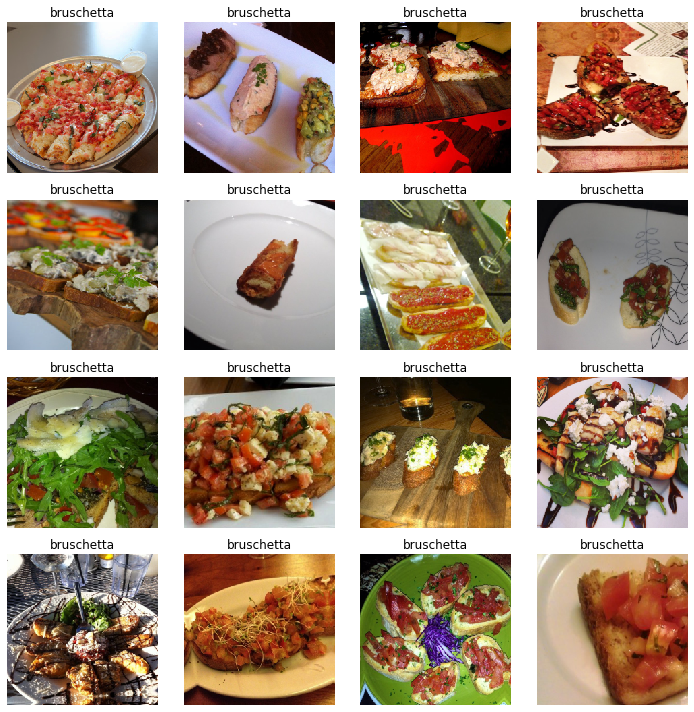

In [18]:
show_class_images(train_data.classes[10])

### 4. Data Augmentation

- `Data augmentation` is perhaps the most important regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (to the human eye) but do change its pixel values. Models trained with data augmentation will then generalize better.

- Define two functions to build class data and show images of each class with data augmentation parameters:
    - `build_class_data_with_tfms` : build class data with data augmentation
    - `show_class_images_with_tfms`: show class images with data augmentation

In [19]:
tfms = get_transforms(max_rotate=15, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [20]:
def build_class_data_with_tfms(class_name, padding_mode):
    
    class_path = path_images/class_name
    fnames = get_image_files(class_path)
    pat = r'/([^/]+)/\d+.jpg$'
    class_data = ImageDataBunch.from_name_re(class_path, fnames, pat, \
                                             ds_tfms=tfms, size=224, \
                                             padding_mode=padding_mode,\
                                             bs=bs)\
                                            .normalize(imagenet_stats)

    return class_data

In [21]:
def show_class_images_with_tfms(class_name,padding_mode, row_number = 4, fig_size = (10,10)):
    
    class_data = build_class_data_with_tfms(class_name,padding_mode)
    print('Class Name: ', class_name)
    class_data.show_batch(rows=row_number, figsize=fig_size)
    
    return

Class Name:  apple_pie


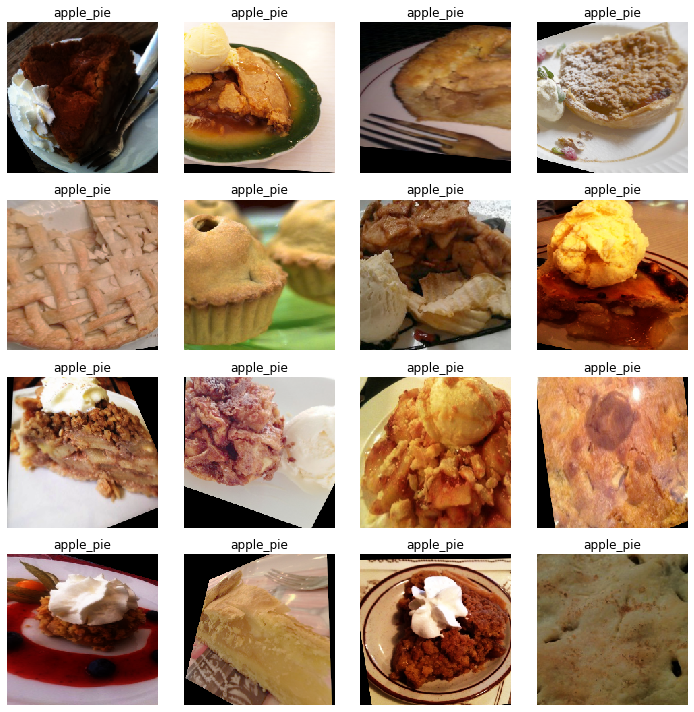

In [22]:
show_class_images_with_tfms(train_data.classes[0],padding_mode = 'zeros')

### Show single image with data augmentation

In [23]:
fnames = get_image_files(path_images/train_data.classes[0])

In [24]:
fnames[1]

PosixPath('food101/images/apple_pie/2969119.jpg')

In [25]:
def show_img_augmentation(image_file_name, rows=3,cols=3,width=9,height=9):
    
    img = open_image(image_file_name)
    print('Image Before/After Augmentation:')
    img.show()
    

    [img.apply_tfms(get_transforms()[0]).show(ax=ax) \
      for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())];
    
    return

    

Image Before/After Augmentation:


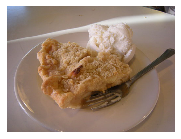

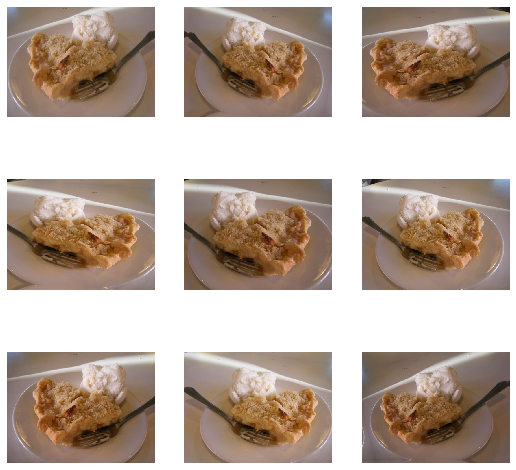

In [26]:
show_img_augmentation(get_image_files(path_images/train_data.classes[0])[10])

### 4. Model Training

- Applying Deep learning models into Food Recognition has achieved a lot of progresses. The popular method is to use pre-trained model and transfer learning. 
- The results of the SoTA models for food classification are as following:
    - **InceptionV3** : by Hassannejad, Hamid, et al. ["Food Image Recognition Using Very Deep Convolutional Networks." Proceedings of the 2nd International Workshop on Multimedia Assisted Dietary Management. ACM, 2016.](http://dl.acm.org/citation.cfm?id=2986042)
        - Top-1 Accuracy : 88.28% 
        - Top-5 Accuracy : 96.88%
        - Augmentation: Flip, Rotation, Color and Zoom
        - Crops: 10 crops for validation
      
    - **ResNet200**: by Keun-dong Lee, et al.[NVIDIA DEEP LEARNING CONTEST 2016.](https://www.gputechconf.co.kr/assets/files/presentations/2-1650-1710_DL_Contest_%EC%A7%80%EC%A0%95%EC%A3%BC%EC%A0%9C_%EB%8C%80%EC%83%81.pdf)
        - Top-1 Accuracy : 90.14% (78 epoch)
        - Crops: Multi-Crops evaluation
    - **WISeR** : by . Martinel,et al. [Wide-Slice Residual Networks for Food Recognition.](https://arxiv.org/pdf/1612.06543.pdf)
        - Top-1 Accuracy : 90.27% 
        - Top-5 Accuracy : 98.71%
        - Augmentation: Flip, Rotation, Color and Zoom
        - Crops: 10 crops for validation
 
- From the SoTA models, the best archtecture is based on ResNet-ish model. I will use the standard **ResNet50** pre-trained model for training
    - First Step: Train images size 224x224 until the *Loss* started to converge
    - Second Step: Train images size 512x512


### 4.1 Set the Data Augmentation Parameters

#### Random Augmentation
- Reference : Fastai [RandTransform](https://docs.fast.ai/vision.image.html#RandTransform) 

- Each argument of `func` in kwargs is analyzed and if it has a type annotaiton that is a random function, this function will be called to pick a value for it. This value will be stored in the `resolved` dictionary. Following the same idea, `**p**`is the probability for func to be called and do_run will be set to True if it was the cause, False otherwise. Setting is_random to False allows to send specific values for each parameter. use_on_y is a parameter to further control transformations for targets (e.g. Segmentation Masks). Assuming transformations on labels are turned on using tfm_y=True (in your Data Blocks pipeline), use_on_y=False can disable the transformation for labels.

- tfms input is a tuple of two Transform lists. The first list is applied on training set, the second one is applied on validation set

In [27]:
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)

# Training Set Random Augmentation
train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]

# validation set Random Augmentation
valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms)


In [28]:

train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=224)\
                            .databunch(bs=bs)\
                            .normalize(imagenet_stats))


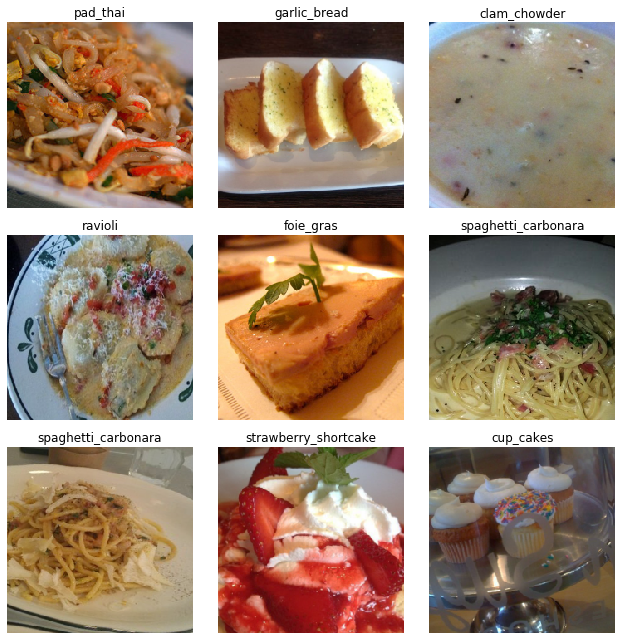

In [29]:
train_model_data.show_batch(rows=3, figsize=(9, 9))


### 4.2 Metrics

**Top-1 Accuracy** and **Top-5 Accuracy** are standard metrics for the image classification problems. I will use the these two metrics to compare with the SoTA results


In [30]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

### 4.3 Model Structure

In [31]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


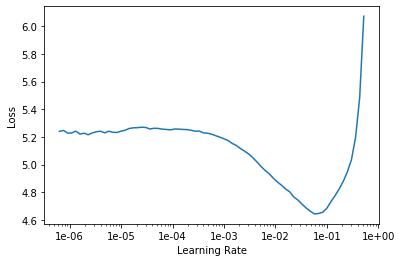

In [33]:
learn.lr_find()
learn.recorder.plot()

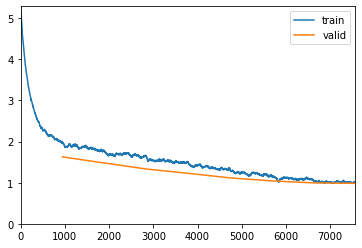

In [34]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-prototype')

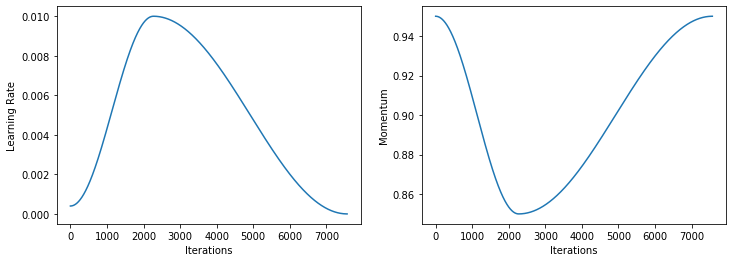

In [36]:
# the learning rate and momentum scheduling 
learn.recorder.plot_lr(show_moms=True)

### 5. Evaluation and Test

- Apply the test augmentation will improve the accuracy. Two ways of evaluation will be performed
    - Without TTA 
    - with TTA

In [37]:
test_model_data = (ImageList.from_df(df=test_df,path=path_images, cols=1)\
                            .split_none()\
                            .label_from_df(cols=0)\
                            .transform(random_tfms,size=224)\
                            .databunch(bs=bs)\
                            .normalize(imagenet_stats))

learn = cnn_learner(test_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)


learn.load('food-101-ResNet50-prototype')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: food101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

### 5.1 Test  Evaluation

In [38]:
learn.validate(test_model_data.train_dl)

[0.7842415, tensor(0.7819), tensor(0.9465)]

### 5.2 Test Time Augmentation Evaluation(TTA)

- Applies Test Time Augmentation to learn on the dataset ds_type. We take the average of our regular predictions (with a weight beta) with the average of predictions obtained through augmented versions of the training set (with a weight 1-beta). The transforms decided for the training set are applied with a few changes scale controls the scale for zoom (which isn't random), the cropping isn't random but we make sure to get the four corners of the image. Flipping isn't random but applied once on each of those corner images (so that makes 8 augmented versions total).

- `beta=0.4, scale=1.35` will applied in TTA prediction

In [39]:
#Model: food-101-ResNet50-1e-57-55-v2-512
y_preds_TTA, y_TTA = learn.TTA(ds_type= test_model_data,beta=0.4, scale=1.35)

top_1_accuracy_TTA = accuracy(y_preds_TTA, y_TTA)
top_5_accuracy_TTA = top_k_accuracy(y_preds_TTA, y_TTA, k=5)

print('TTA: top_1_accuracy: ',top_1_accuracy_TTA )
print('TTA: top_5_accuracy: ',top_5_accuracy_TTA )

TTA: top_1_accuracy:  tensor(0.8158)
TTA: top_5_accuracy:  tensor(0.9579)
